## Financial Data Analysis
Climate data is from the world bank; read more about these time series [here](https://climateknowledgeportal.worldbank.org/country/uruguay/climate-data-historical).

In [ ]:
!pip install statsmodels --upgrade
!pip install yfinance

All available NASDAQ listings: 
   Symbol  ... Round Lot Size
0   AAIT  ...          100.0
1    AAL  ...          100.0
2   AAME  ...          100.0
3   AAOI  ...          100.0
4   AAON  ...          100.0

[5 rows x 7 columns]
Sample of MSFT stock series: 
                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2009-06-01  21.000000  21.500000  20.860001  21.400000  16.364052  57317100
2009-06-02  21.360001  21.980000  21.200001  21.400000  16.364052  48935700
2009-06-03  21.309999  21.760000  21.290001  21.730000  16.616404  56039600
2009-06-04  21.770000  21.900000  21.580000  21.830000  16.692871  42330000
2009-06-05  21.959999  22.309999  21.809999  22.139999  16.929914  59579200


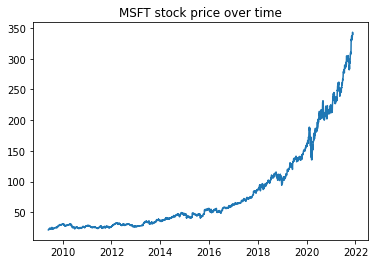

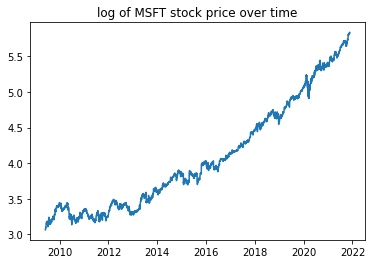

In [ ]:
"""
No need to change this block - loads dataset and necessary packages
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import yfinance as yf
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
print("All available NASDAQ listings: \n", companies.head())
msft = yf.download("MSFT",start='2009-06-01',progress=False)
print("Sample of MSFT stock series: \n", msft.head())
price = msft.reset_index()['Close'].values.reshape(-1,1)
date = msft.reset_index().Date.dt.date.values.reshape(-1,1)
plt.plot(date, price)
plt.title("MSFT stock price over time")
plt.show()
log_price = np.log(price)
plt.plot(date, log_price)
plt.title("log of MSFT stock price over time")
plt.show()

### Transform Data to Stationary
Here, transform the time series to a stationary series. 

Recall your tools from the last couple weeks (you may find it helpful to refer to the solutions from last week [here](https://colab.research.google.com/drive/1vJmoFJu0rSKdLZOqinD6Czr1vrVaEAIl?usp=sharing). 
Recall that a stationary time series: 
1. Has no trend
2. Has no seasonal component
3. Has constant variance 


At the end of this investigation, you should have a stationary variable `stationary_price` that is a stationary transformation of your price data. 

[[0.00080362]]


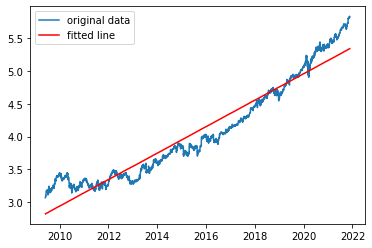

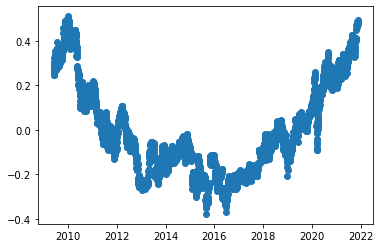

MSE with linear fit: 0.042578818730483484


In [ ]:
## Here, add code to apply the necessary transformations. 
# Include any plots that help support your claim. 
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = msft.reset_index().index.values.reshape(-1,1)
clf.fit(index, log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(index)
plt.plot(date, log_price, label='original data')
plt.plot(date, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = log_price - linear_prediction
plt.plot(date, linear_residuals, 'o')
plt.show();
print("MSE with linear fit:", np.mean((linear_residuals)**2))


In [ ]:
len(msft)

3144

[[-2.22635361e-05  2.62767920e-07]]


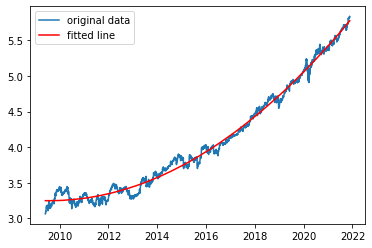

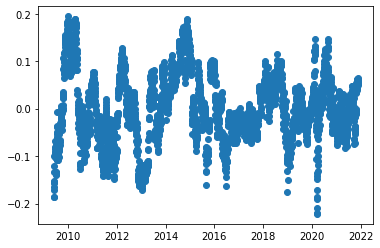

MSE with linear fit: 0.0050986003358636095


In [ ]:
## After linear fit, it seems like a higher order model is needed
clf = linear_model.LinearRegression()
index = msft.reset_index().index.values.reshape(-1,1)

new_x = np.hstack((index, index **2))
clf.fit(new_x, log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='original data')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show();
print("MSE with linear fit:", np.mean((quad_residuals)**2))

In [ ]:
index = np.arange(len(index) + 4).reshape(-1,1)
new_x = np.hstack((index, index **2))
quad_prediction = clf.predict(new_x)
quad_prediction[-4:]

array([[5.78994017],
       [5.79157466],
       [5.79320968],
       [5.79484522]])

In [ ]:
np.exp(quad_prediction[-4:])

array([[326.99346136],
       [327.52836535],
       [328.06431675],
       [328.60131784]])

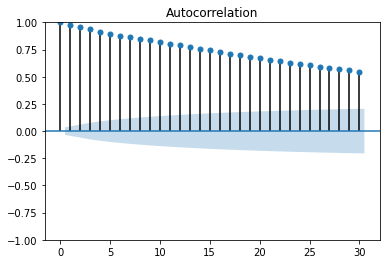

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


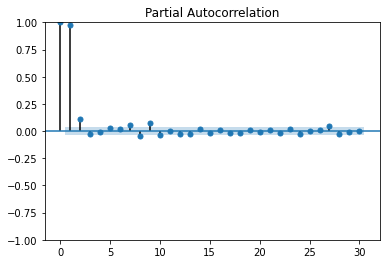

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(quad_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(quad_residuals, lags=30)
plt.show();

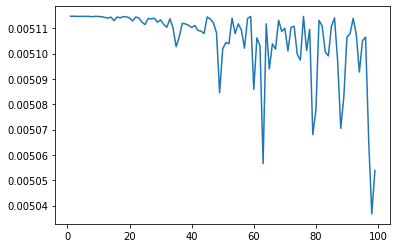

minimizing period is: 98


In [ ]:
|# Not strong evidence, from PACF or experimenting with period values, of seasonality
from scipy import optimize
period_range = np.arange(1, 100)
mse_list = []

def find_sine_approximation(period, x_data=date, y_data=log_price):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period, index, quad_residuals)
  mse = np.nanmean((quad_residuals - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)

In [ ]:
stationary_price = quad_residuals

In [ ]:
# We'll be evaluating how well various models forecast - to do so, we split the data
# into train/test sets using the first 80% of the observations as training data
train_test_split = int(len(price) * 0.8)
train_price, test_price = stationary_price[:train_test_split], stationary_price[train_test_split:]
train_date, test_date = date[:train_test_split], date[train_test_split:]
assert(len(train_date) + len(test_date) == len(date))

In [ ]:
# No need to change this block - defines AIC/BIC
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, np.mean(residuals), scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, np.mean(residuals), scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

### Find ACF/PACT of Stock Price Data
Plot the ACF and PACF. Use the package referenced [here (ACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) and [here (PACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html).

What does this suggest about the AR/MA order of the model? 

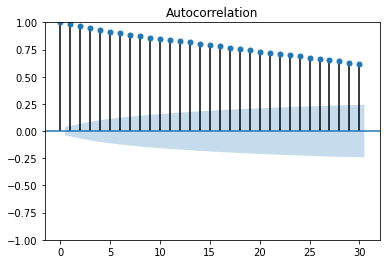

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


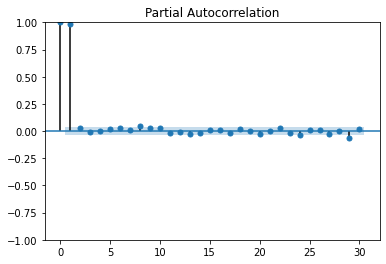

In [ ]:
import statsmodels as sm
sm.api.graphics.tsa.plot_acf(train_price, lags=30)
plt.show()
sm.api.graphics.tsa.plot_pacf(train_price, lags=30)
plt.show()

### Fitting AR models
Fit an AR(1) model to the data. Plot the model fit, residuals, and find the AIC and BIC. 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2511
Model:               SARIMAX(1, 0, 0)   Log Likelihood                7124.737
Date:                Mon, 15 Nov 2021   AIC                         -14245.474
Time:                        21:09:05   BIC                         -14233.817
Sample:                             0   HQIC                        -14241.243
                               - 2511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9810      0.003    301.646      0.000       0.975       0.987
sigma2         0.0002   2.68e-06     74.940      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   2.19   Jarque-

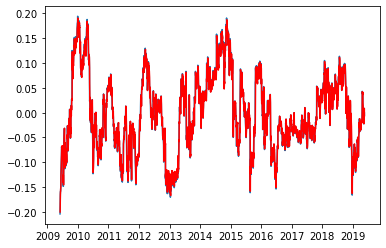

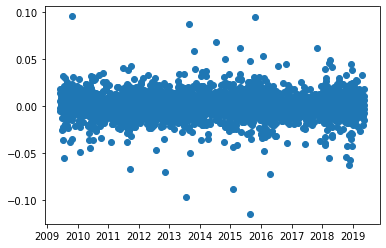

MSE with AR(1) model: 0.00020009508734488232
AIC with AR(1) model: -14249.960405837417
BIC with AR(1) model: -14238.304329773166


In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

ar_1 = SARIMAX(train_price, order=(1, 0, 0)).fit()
print(ar_1.summary())
ar_1_predictions = ar_1.predict()
ar_1_residuals = train_price - ar_1_predictions.reshape(-1,1)
ar_1_residuals = ar_1_residuals[1:] # Fitting AR 1 model means removing one observation
plt.plot(train_date, train_price, label='original data')
plt.plot(train_date[1:], ar_1_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(train_date[1:], ar_1_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_1_residuals**2))
print("AIC with AR(1) model:", evaluate_AIC(2, ar_1_residuals))
print("BIC with AR(1) model:", evaluate_BIC(2, ar_1_residuals))

### Higher order AR models
Fit higher-order AR models to the data. Do these improve the fit? 
Based on the ACF/PACF models, would you expect them to? 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2511
Model:               SARIMAX(5, 0, 0)   Log Likelihood                7126.423
Date:                Mon, 15 Nov 2021   AIC                         -14240.846
Time:                        20:38:44   BIC                         -14205.875
Sample:                             0   HQIC                        -14228.153
                               - 2511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9529      0.016     59.470      0.000       0.921       0.984
ar.L2          0.0389      0.024      1.653      0.098      -0.007       0.085
ar.L3         -0.0069      0.025     -0.278      0.7

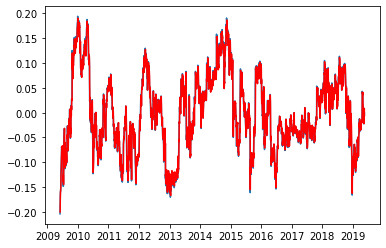

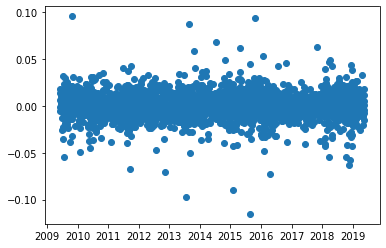

MSE with AR(1) model: 0.0001998360349933583
AIC with AR(1) model: -14245.217372749403
BIC with AR(1) model: -14210.249144556648


In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
AR_order = 5
ar_higher = SARIMAX(train_price, order=(AR_order, 0, 0)).fit()
print(ar_higher.summary())
ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = train_price - ar_higher_predictions.reshape(-1,1)
ar_higher_residuals = ar_higher_residuals[1:] # Fitting AR 1 model means removing one observation
plt.plot(train_date, train_price, label='original data')
plt.plot(train_date[1:], ar_higher_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(train_date[1:], ar_higher_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_higher_residuals**2))
print("AIC with AR(1) model:", evaluate_AIC(AR_order + 1, ar_higher_residuals))
print("BIC with AR(1) model:", evaluate_BIC(AR_order + 1, ar_higher_residuals))

In [ ]:
ar_higher.aic

-13629.428709618449

### ARMA Models
Varying the AR and MA parameters, find an optimal fit to the dataset. 
Is it what you expect from the ACF/PACF plots? 

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
min_aic = np.inf 
min_bic = np.inf
min_aic_index = None
min_bic_index = None 
for AR_order in range(5):
  for MA_order in range(5):
    arma = SARIMAX(train_price, order=(AR_order, 0, MA_order)).fit()
    if arma.aic < min_aic:
      min_aic = arma.aic
      min_aic_index = (AR_order, 0, MA_order)
    if arma.bic < min_bic:
      min_bic = arma.bic
      min_bic_index = (AR_order, 0, MA_order)
print("Minimizing AIC order: ", min_aic_index)
print("Minimizing BIC order: ", min_bic_index )
if min_aic_index == min_bic_index:
  arma = SARIMAX(train_price, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = train_price - arma_predictions.reshape(-1,1)
  arma_residuals = arma_residuals[1:] # Fitting AR 1 model means removing one observation
  plt.plot(train_date, train_price, label='original data')
  plt.plot(train_date[1:], arma_predictions[1:], 'r', label='fitted line')
  plt.show()
  plt.plot(train_date[1:], arma_residuals, 'o')
  plt.show()
  print("MSE with selected model:", np.mean(arma_residuals**2))
  print("AIC with selected model:", evaluate_AIC(sum(min_aic_index)+ 1, arma_residuals))
  print("BIC with selected model:", evaluate_BIC(sum(min_bic_index) + 1, arma_residuals))
else:
  print("AIC, BIC do not agree.")

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Minimizing AIC order:  (2, 0, 0)
Minimizing BIC order:  (1, 0, 0)
AIC, BIC do not agree.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2511
Model:               SARIMAX(2, 0, 0)   Log Likelihood                7125.830
Date:                Mon, 15 Nov 2021   AIC                         -14245.660
Time:                        21:01:31   BIC                         -14228.175
Sample:                             0   HQIC                        -14239.314
                               - 2511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9524      0.016     59.465      0.000       0.921       0.984
ar.L2          0.0292      0.016      1.801      0.072      -0.003       0.061
sigma2         0.0002   2.68e-06     74.768      0.0

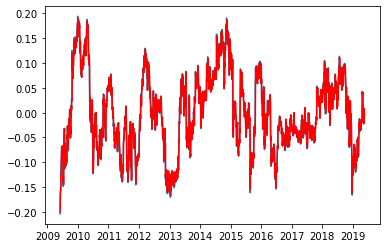

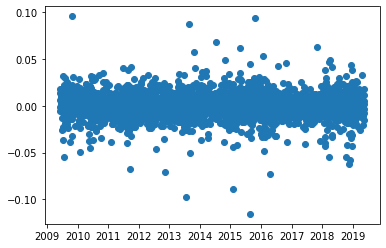

MSE with selected model: 0.00019992388553717364
AIC with selected model: -14250.113652827602
BIC with selected model: -14240.45757676335


In [ ]:
arma = SARIMAX(train_price, order=min_aic_index).fit()
print(arma.summary())
arma_predictions = arma.predict()
arma_residuals = train_price - arma_predictions.reshape(-1,1)
arma_residuals = arma_residuals[1:] # Fitting AR 1 model means removing one observation
plt.plot(train_date, train_price, label='original data')
plt.plot(train_date[1:], arma_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(train_date[1:], arma_residuals, 'o')
plt.show()
print("MSE with selected model:", np.mean(arma_residuals**2))
print("AIC with selected model:", evaluate_AIC(sum(min_aic_index)+ 1, arma_residuals))
print("BIC with selected model:", evaluate_BIC(sum(min_bic_index) + 1, arma_residuals))

### Forecasting
Use your preferred model to forecast the remaining time series. 
Plot this on the same axes as the true values, and include the confidence intervals around your forecast. 

Refer to the guide [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html) for an example of how to use this forecasting package. 

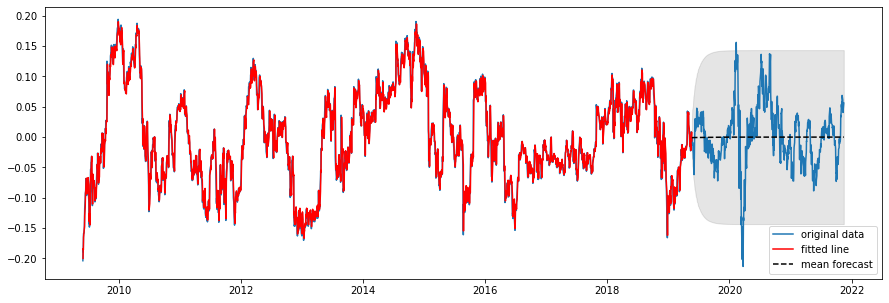

In [ ]:
# arma = <ADD CODE FOR YOUR PREFERRED ARMA MODEL HERE>
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, stationary_price, label='original data')
predicted_values = arma_predictions[1:].reshape(-1,1)
ax.plot(train_date[1:], predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();

## Collapse to Monthly Values
Here, we repeat the exercises above, but start with a dataset that's collapsed to monthly values. 

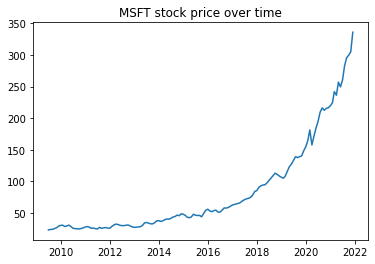

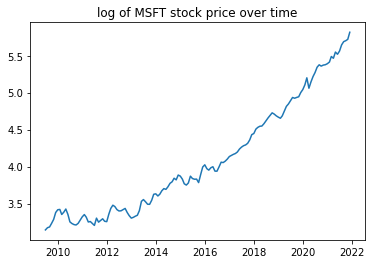

In [ ]:
collapsed = msft.groupby(pd.Grouper(freq ='M')).mean()
month_date = collapsed.reset_index().Date.dt.date.values.reshape(-1,1)
month_price = collapsed.High.values.reshape(-1,1)
month_log_price = np.log(month_price)
plt.plot(month_date, month_price)
plt.title("MSFT stock price over time")
plt.show()
plt.plot(month_date, month_log_price)
plt.title("log of MSFT stock price over time")
plt.show()

[[-0.00043917  0.00011624]]


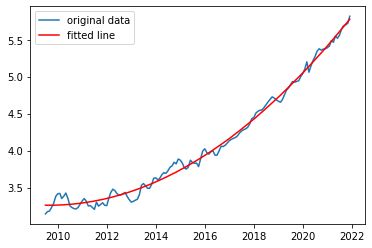

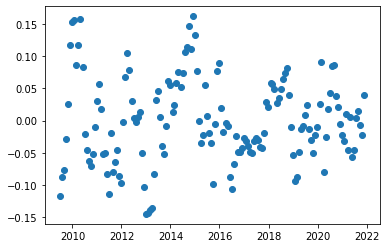

MSE with linear fit: 0.004407394731260791


In [ ]:
clf = linear_model.LinearRegression()
index = collapsed.reset_index().index.values.reshape(-1,1)
new_x = np.hstack((index, index **2))
clf.fit(new_x, month_log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
month_quad_prediction = clf.predict(new_x)
plt.plot(month_date, month_log_price, label='original data')
plt.plot(month_date, month_quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
month_quad_residuals = month_log_price - month_quad_prediction
plt.plot(month_date, month_quad_residuals, 'o')
plt.show();
print("MSE with linear fit:", np.mean((month_quad_residuals)**2))

In [ ]:
month_train_test = int(0.8 * len(month_date))
month_train, month_test = month_quad_residuals[:month_train_test], month_quad_residuals[month_train_test:]
month_date_train, month_date_test = month_date[:month_train_test], month_date[month_train_test:]

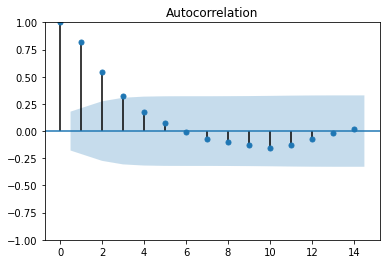

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


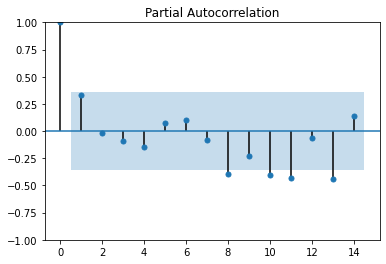

In [ ]:
sm.api.graphics.tsa.plot_acf(month_train, lags=14)
plt.show()
sm.api.graphics.tsa.plot_pacf(month_test, lags=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood op

Minimizing AIC order:  (2, 0, 0)
Minimizing BIC order:  (2, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 226.480
Date:                Mon, 15 Nov 2021   AIC                           -446.960
Time:                        21:34:47   BIC                           -438.598
Sample:                             0   HQIC                          -443.564
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1696      0.083     14.025      0.000       1.006       1.333
ar.L2         -0.4095      0.075     -5.433      0.000      -0.55

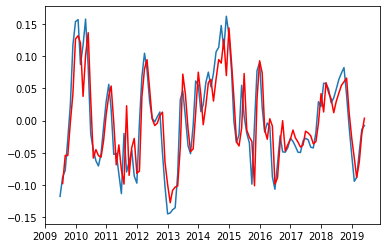

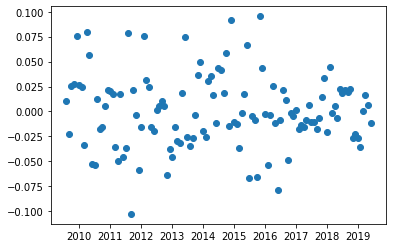

MSE with selected model: 0.0013074775245401566
AIC with selected model: -446.4384290538186
BIC with selected model: -438.101058574484


In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
min_aic = np.inf 
min_bic = np.inf
min_aic_index = None
min_bic_index = None 
for AR_order in range(5):
  for MA_order in range(5):
    arma = SARIMAX(month_train, order=(AR_order, 0, MA_order)).fit()
    if arma.aic < min_aic:
      min_aic = arma.aic
      min_aic_index = (AR_order, 0, MA_order)
    if arma.bic < min_bic:
      min_bic = arma.bic
      min_bic_index = (AR_order, 0, MA_order)
print("Minimizing AIC order: ", min_aic_index)
print("Minimizing BIC order: ", min_bic_index )
if min_aic_index == min_bic_index:
  arma = SARIMAX(month_train, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = month_train - arma_predictions.reshape(-1,1)
  arma_residuals = arma_residuals[1:] # Fitting AR 1 model means removing one observation
  plt.plot(month_date_train, month_train, label='original data')
  plt.plot(month_date_train[1:], arma_predictions[1:], 'r', label='fitted line')
  plt.show()
  plt.plot(month_date_train[1:], arma_residuals, 'o')
  plt.show()
  print("MSE with selected model:", np.mean(arma_residuals**2))
  print("AIC with selected model:", evaluate_AIC(sum(min_aic_index)+ 1, arma_residuals))
  print("BIC with selected model:", evaluate_BIC(sum(min_bic_index) + 1, arma_residuals))
else:
  print("AIC, BIC do not agree.")

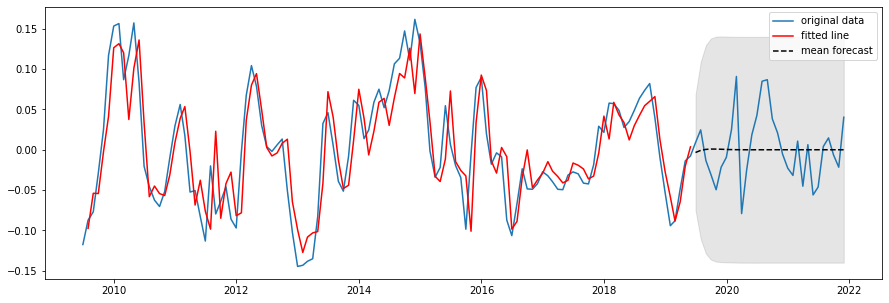

In [ ]:
arma = SARIMAX(month_train, order=min_bic_index).fit()
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(month_test)).summary_frame()

arma_predictions = arma.predict()
ax.plot(month_date, month_quad_residuals, label='original data')
predicted_values = arma_predictions[1:].reshape(-1,1)
ax.plot(month_date_train[1:], predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
ax.plot(month_date_test, forecast_means, 'k--', label='mean forecast')
ax.fill_between(month_date_test.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();